In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import os
import pandas as pd
import numpy as np
import math

import sys
sys.path.append("../..")
from src.load_datasets import load_dataset, load_rankings, load_train_data
import src.evaluate_regression

# From example
import src.encoder_utils as eu
import src.evaluate_regression as er
import src.load_datasets as ld
import src.pairwise_utils as pu

from category_encoders import OneHotEncoder
from pathlib import Path
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier

import xgboost
import catboost 
import lightgbm

# Example

- With CV
- Without preprocessing

In [ ]:
# Define variables for ranking
factors = ["dataset", "model", "tuning", "scoring"]
new_index = "encoder"
target = "rank"

In [ ]:
df_train = load_dataset("../../data/raw/dataset_rank_train.csv")

if "cv_score" in df_train.columns:
    df_train = df_train.drop("cv_score", axis=1)

X_train = df_train.drop(target, axis=1)
y_train = df_train[target]

In [ ]:
# For pairwise methods: 
X_train = df_train[factors + ["encoder"]].groupby(factors).agg(lambda x: np.nan).reset_index()[factors]
print(X_train.shape)
X_train.head()

In [ ]:
y_train = pd.merge(X_train,
                   pu.get_pairwise_target(df_train, features=factors, target="rank", column_to_compare="encoder"),
                   on=factors, how="left").drop(factors, axis=1).fillna(0)
print(y_train.shape)
y_train.head()

In [ ]:
target = list(y_train.columns)
cv_indices = src.evaluate_regression.custom_cross_validated_indices(pd.concat([X_train, y_train], axis=1), 
                                                                    factors, 
                                                                    target,  #target 
                                                                    n_splits=5, 
                                                                    shuffle=True, 
                                                                    random_state=1444)

In [ ]:
for fold in cv_indices:
    X_tr = X_train.iloc[fold[0]]
    X_te = X_train.iloc[fold[1]]
    y_tr = y_train.iloc[fold[0]]
    y_te = y_train.iloc[fold[1]]
    
    dummy_pipe = Pipeline([("encoder", eu.NoY(OneHotEncoder())), ("model", DecisionTreeClassifier())])
    y_pred = pd.DataFrame(dummy_pipe.fit(X_tr, y_tr).predict(X_te), columns=y_tr.columns, index=X_te.index)
    # In contrast to the example use df_train
    # It should do the same, since a inner join is used and the other part consists of X_te
    tmp = pu.join_pairwise2rankings(X_te, y_pred, factors)
    df_pred = pd.merge(df_train,
                       tmp,
                       on=factors + ["encoder"], how="inner")
    
    rankings_test = er.get_rankings(df_pred, factors=factors, new_index=new_index, target="rank")
    rankings_pred = er.get_rankings(df_pred, factors=factors, new_index=new_index, target="rank_pred")
    print(er.average_spearman(rankings_test, rankings_pred))

# Example
 
- With CV
- With preprocessing

In [3]:
# Define variables for ranking
factors = ["dataset", "model", "tuning", "scoring"]
new_index = "encoder"
target = "rank"

In [4]:
df_train = load_dataset("../../data/raw/dataset_rank_train.csv")

if "cv_score" in df_train.columns:
    df_train = df_train.drop("cv_score", axis=1)

X_train = df_train.drop(target, axis=1)
y_train = df_train[target]

Loading data from '../../data/raw/dataset_rank_train.csv' ...


In [5]:
# For pairwise methods: 
X_train = df_train[factors + ["encoder"]].groupby(factors).agg(lambda x: np.nan).reset_index()[factors]
print(X_train.shape)
X_train.head()

(1161, 4)


,dataset,model,tuning,scoring
0,3,DTC,full,ACC
1,3,DTC,full,AUC
2,3,DTC,full,F1
3,3,DTC,model,AUC
4,3,DTC,model,F1


In [6]:
y_train = pd.merge(X_train,
                   pu.get_pairwise_target(df_train, features=factors, target="rank", column_to_compare="encoder"),
                   on=factors, how="left").drop(factors, axis=1).fillna(0)
print(y_train.shape)
y_train.head()

(1161, 992)


,"(BUCV2RGLMME, BUCV2TE)","(BUCV2TE, BUCV2RGLMME)","(BUCV2RGLMME, CBE)","(CBE, BUCV2RGLMME)","(BUCV2RGLMME, CE)","(CE, BUCV2RGLMME)","(BUCV2RGLMME, CV10RGLMME)","(CV10RGLMME, BUCV2RGLMME)","(BUCV2RGLMME, CV10TE)","(CV10TE, BUCV2RGLMME)",...,"(OHE, TE)","(TE, OHE)","(OHE, WOEE)","(WOEE, OHE)","(OHE, SE)","(SE, OHE)","(SE, TE)","(TE, SE)","(SE, WOEE)","(WOEE, SE)"
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


### Preprocessing

- Do not preprocess (embed) the encoder features (because it is not present in this task)

In [7]:
import src.encoding
from src.feature_engineering import normalize_train_data, normalize_test_data
from src.meta_information import add_dataset_meta_information
from src.data_cleaning import drop_pearson_correlated_features

In [8]:
base_df = df_train.copy()
print(base_df.columns)

Index(['dataset', 'model', 'tuning', 'scoring', 'encoder', 'rank'], dtype='object')


In [9]:
# OHE encoding 
X_train, ohe = src.encoding.ohe_encode_train_data(X_train=X_train,
                                                  cols_to_encode=["model", "tuning", "scoring"],
                                                  verbosity=2)

One Hot Encoding the features ['model', 'tuning', 'scoring'] of the train data ...


In [10]:
base_df_mod = src.encoding.ohe_encode_test_data(X_test=base_df,
                                                cols_to_encode=["model", "tuning", "scoring"],
                                                ohe=ohe, 
                                                verbosity=2)

One Hot Encoding the features ['model', 'tuning', 'scoring'] of the test data ...


In [11]:
X_train = add_dataset_meta_information(df=X_train,
                                       path_to_meta_df="../../data/preprocessed/dataset_agg.csv",
                                       nan_threshold=0.5,
                                       replacing_strategy="median")

In [12]:
X_train, _ = drop_pearson_correlated_features(train_data=X_train, 
                                              test_data=X_train, 
                                              threshold=0.7, 
                                              verbosity=2)

Drop pearson correlated features with threshold 0.7...
Filter correlated features


In [13]:
print(list(X_train.columns))

['dataset', 'model_DTC', 'model_KNC', 'model_LGBMC', 'model_LR', 'model_SVC', 'tuning_full', 'tuning_model', 'tuning_no', 'scoring_ACC', 'scoring_AUC', 'scoring_F1', 'Quartile1KurtosisOfNumericAtts', 'J48.001.ErrRate', 'Dimensionality', 'Quartile2MutualInformation', 'MinSkewnessOfNumericAtts', 'Quartile2AttributeEntropy', 'MinorityClassSize', 'MajorityClassPercentage', 'Quartile2StdDevOfNumericAtts', 'NumberOfBinaryFeatures', 'Quartile1MutualInformation', 'Quartile1MeansOfNumericAtts', 'MaxMutualInformation', 'AutoCorrelation', 'PercentageOfBinaryFeatures', 'MinKurtosisOfNumericAtts', 'DecisionStumpErrRate', 'PercentageOfNumericFeatures', 'NumberOfSymbolicFeatures', 'MinMutualInformation', 'PercentageOfInstancesWithMissingValues', 'MinNominalAttDistinctValues', 'NumberOfNumericFeatures', 'rows_with_null_values_count', 'categorical_target_variables_count', 'non_categorical_target_variables_count', 'categorical_target_values_sum', 'min_number_of_categories_per_cat_feature']


In [14]:
print(list(base_df_mod.columns))

['dataset', 'encoder', 'rank', 'model_DTC', 'model_KNC', 'model_LGBMC', 'model_LR', 'model_SVC', 'tuning_full', 'tuning_model', 'tuning_no', 'scoring_ACC', 'scoring_AUC', 'scoring_F1']


In [15]:
new_factors = ['dataset', 
               'model_DTC', 
               'model_KNC', 
               'model_LGBMC', 
               'model_LR', 
               'model_SVC', 
               'tuning_full', 
               'tuning_model', 
               'tuning_no', 
               'scoring_ACC', 
               'scoring_AUC', 
               'scoring_F1']
new_factors = list(base_df_mod.columns)
new_factors.remove("rank")
new_factors.remove("encoder")

### Predict with CV

In [16]:
target = list(y_train.columns)
factors = list(X_train.columns)
cv_indices = src.evaluate_regression.custom_cross_validated_indices(pd.concat([X_train, y_train], axis=1), 
                                                                    factors, 
                                                                    target,  #target 
                                                                    n_splits=5, 
                                                                    shuffle=True, 
                                                                    random_state=1444)

In [17]:
# One could try the multi output classifier
from sklearn.multioutput import MultiOutputClassifier

In [19]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
dt = DecisionTreeClassifier(random_state=42)
et = ExtraTreeClassifier(random_state=42)
ets = ExtraTreesClassifier(random_state=42, n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
svc = LinearSVC(random_state=42)  
rnc = RadiusNeighborsClassifier(n_jobs=-1, radius=5)
gpc = GaussianProcessClassifier(random_state=42)  
rid = RidgeClassifier(random_state=42)
mlp = MLPClassifier(random_state=42, max_iter=1000)  # Increased max iter due to non-convergence exception in last run

xgb = xgboost.XGBClassifier(random_state=42, n_jobs=-1)
lgbm = lightgbm.LGBMClassifier(random_state=42, n_jobs=-1)
cb = catboost.CatBoostClassifier(random_seed=42)
# ToDo:
# LGBM
# CatBoost

In [20]:
#models = [rf, dt, et, ets, knn, svc, rnc, gpc, rid, mlp, xgb]
models = [rf, dt, et, ets, knn, rnc, rid, mlp, xgb] 
#models = [cb]
scores = {str(model).split('(')[0] : []
             for model in models}

In [21]:
for model in models:
    print(f"{model}")
    
    tmp_scores = []
    for fold in cv_indices:
        # Get train and test data for current split
        X_tr = X_train.iloc[fold[0]].copy()
        X_te = X_train.iloc[fold[1]].copy()
        y_tr = y_train.iloc[fold[0]].copy()
        y_te = y_train.iloc[fold[1]].copy()
        
        # Setup pipeline / model
        pipeline = Pipeline([("scaler", MinMaxScaler()), ("model", model)])
        
        # Train and predict
        y_pred = pd.DataFrame(pipeline.fit(X_tr, y_tr).predict(X_te), columns=y_tr.columns, index=X_te.index)
        
        # Evaluate with given functions
        tmp = pu.join_pairwise2rankings(X_te, y_pred, factors)
        df_pred = pd.merge(base_df_mod,
                           tmp,
                           on=new_factors + ["encoder"], how="inner")
        rankings_test = er.get_rankings(df_pred, factors=new_factors, new_index=new_index, target="rank")
        rankings_pred = er.get_rankings(df_pred, factors=new_factors, new_index=new_index, target="rank_pred")
        tmp_scores.append(er.average_spearman(rankings_test, rankings_pred))
    
    # Add score and std to dicts for plots
    m = str(model).split('(')[0]
    scores[m] = tmp_scores
    
    # Print scores
    print(f"Avg Spearman: {round(np.mean(scores[m]), 4)} +/- {round(np.std(scores[m]), 4)}")
    print("")

RandomForestClassifier(n_jobs=-1, random_state=42)
Avg Spearman: 0.7113 +/- 0.0195

DecisionTreeClassifier(random_state=42)
Avg Spearman: 0.7425 +/- 0.0065

ExtraTreeClassifier(random_state=42)
Avg Spearman: 0.5618 +/- 0.0156

ExtraTreesClassifier(n_jobs=-1, random_state=42)
Avg Spearman: 0.7502 +/- 0.0177

KNeighborsClassifier(n_jobs=-1)
Avg Spearman: 0.2808 +/- 0.018

RadiusNeighborsClassifier(n_jobs=-1, radius=5)
Avg Spearman: 0.1615 +/- 0.014

RidgeClassifier(random_state=42)
Avg Spearman: 0.3887 +/- 0.022

MLPClassifier(max_iter=1000, random_state=42)


/home/i40/dbprak14/phase-2/venv-phase-2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/i40/dbprak14/phase-2/venv-phase-2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/i40/dbprak14/phase-2/venv-phase-2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/i40/dbprak14/phase-2/venv-phase-2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization has

Avg Spearman: 0.5497 +/- 0.0182

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
Avg Spearman: 0.7291 +/- 0.012



# Plots

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt


# figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set()
sns.set_theme(style="whitegrid")
#sns.set_palette(palette="Set2")
sns.set_palette(palette="Paired")
# set seed
np.random.seed(7)

In [24]:
df_plot = pd.DataFrame(data=scores).T

ms = []
ss = []
fs = []
# Iterate over models
for m in scores.keys():
    # Iterate over folds
    for f in range(5):
        ms.append(m)
        fs.append(f)
        ss.append(scores[m][f])

data = {
    "model": ms,
    "fold": fs,
    "score": ss
}
#print(ms)
df_plot = pd.DataFrame(data=data)
#df_plot

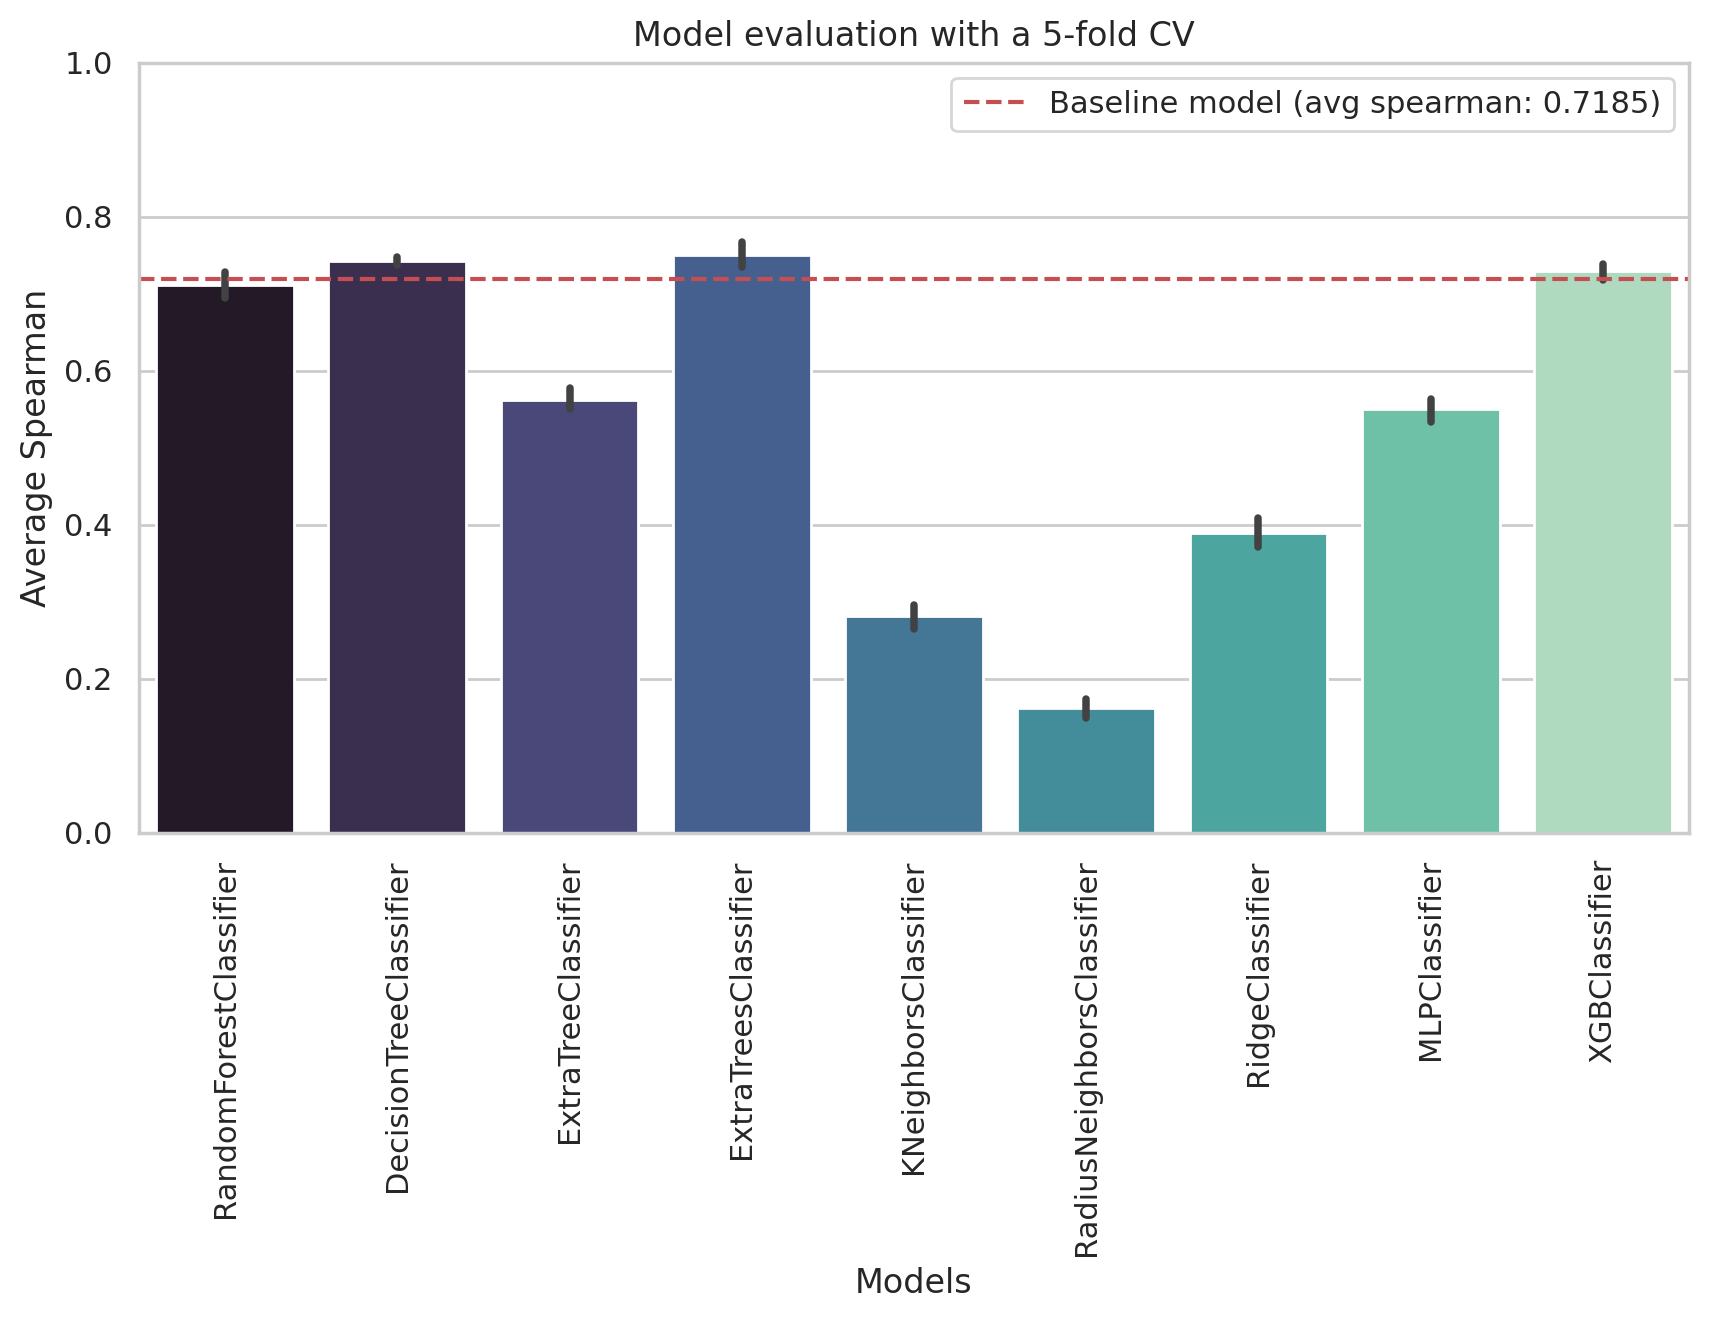

In [57]:
fig, axes = plt.subplots(figsize=(10, 5), nrows=1, ncols=1)
plot = sns.barplot(data=df_plot, x="model", y="score", palette="mako")  # ax=axes, 
plot.axhline(0.7185, color='r', ls='--', label='Baseline model (avg spearman: 0.7185)')
plot.set(title="Model evaluation with a 5-fold CV")
plot.set_ylim([0.0, 1.0])
plot.legend()

plot.set_xlabel("Models")
plot.set_ylabel("Average Spearman")

# Save figures
f = plot.get_figure()
f.savefig("Model_evaluation_mako.png") 
f.savefig("Model_evaluation_mako.svg")

# Rotate items on x axis
for item in axes.get_xticklabels():
        item.set_rotation(90)

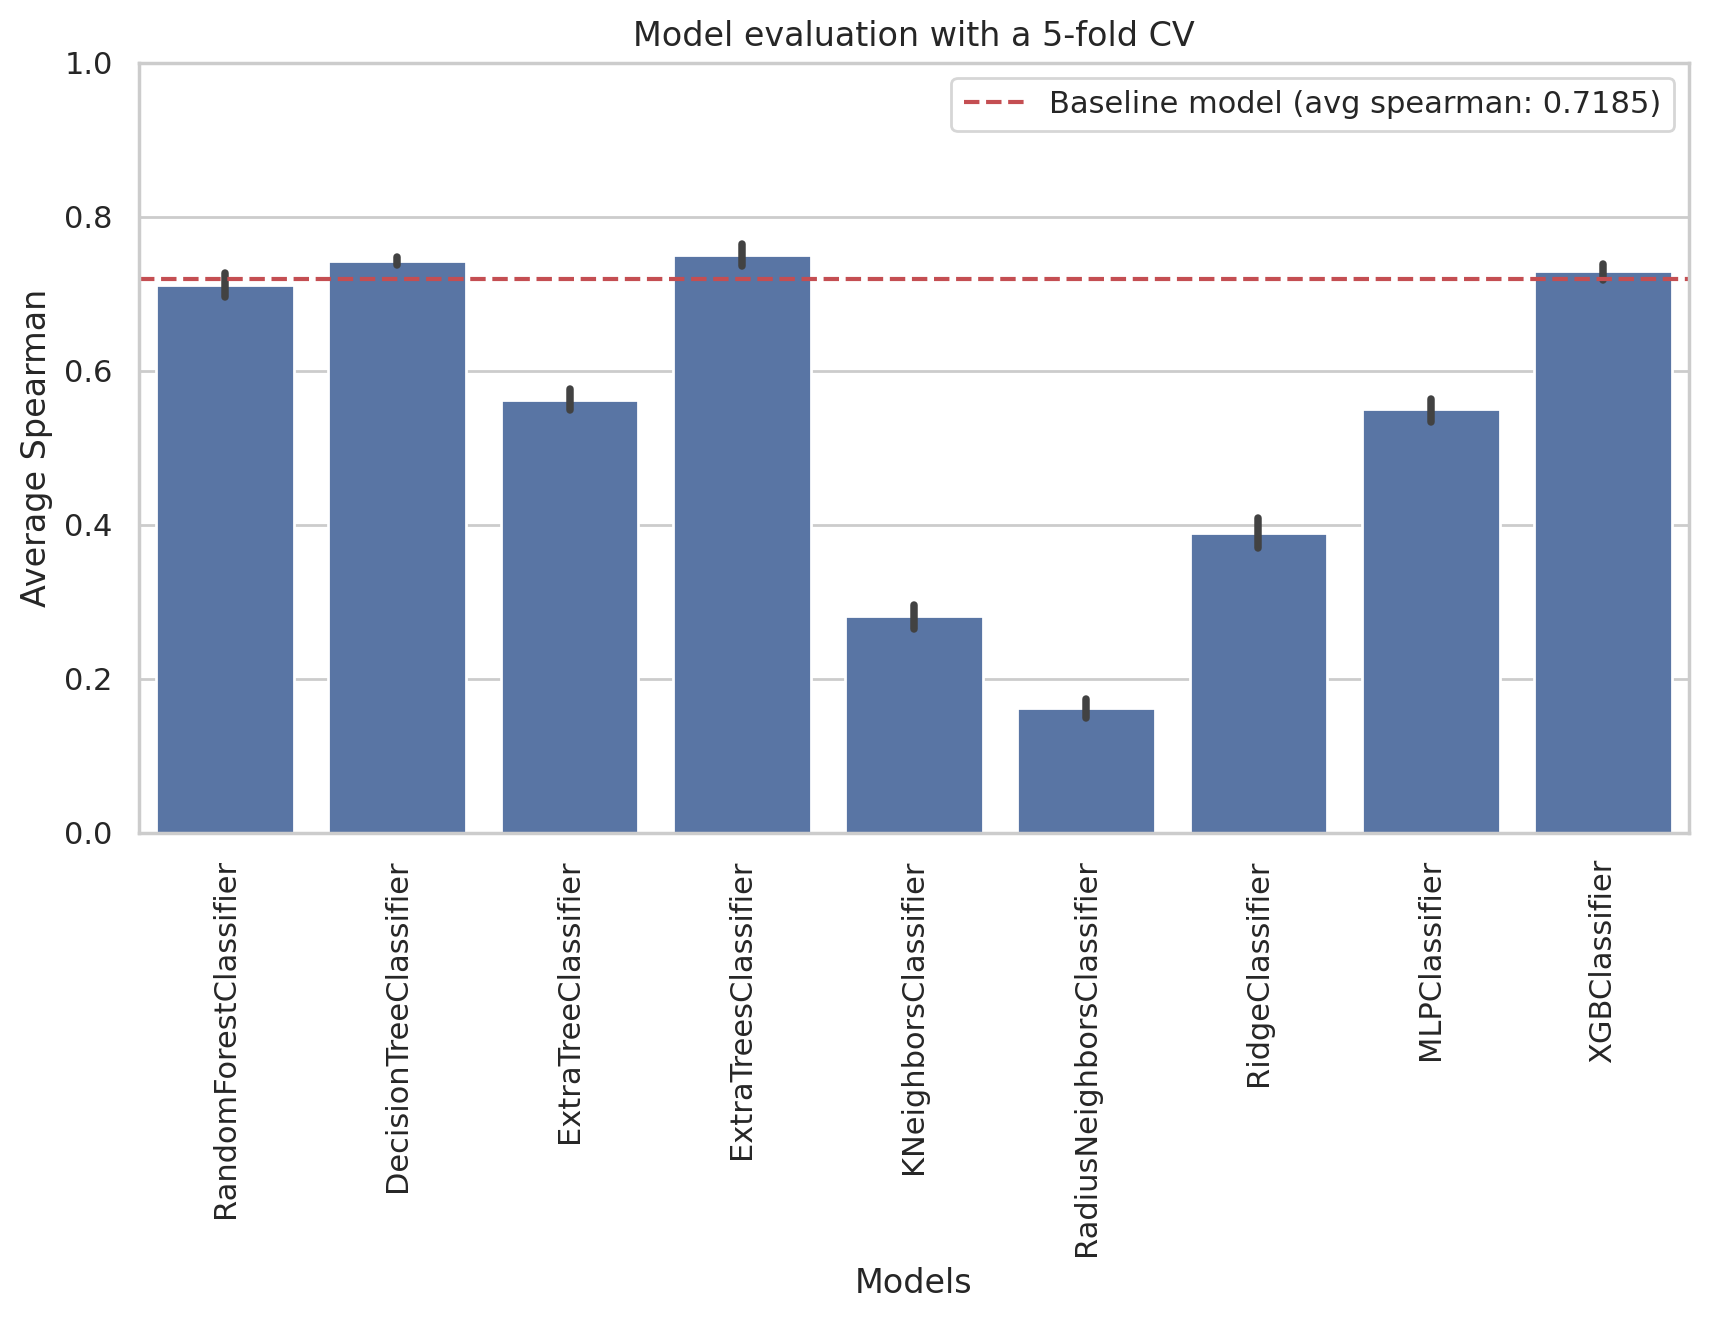

In [58]:
fig, axes = plt.subplots(figsize=(10, 5), nrows=1, ncols=1)
plot = sns.barplot(data=df_plot, x="model", y="score", ax=axes, color="b")
plot.axhline(0.7185, color='r', ls='--', label='Baseline model (avg spearman: 0.7185)')
plot.set(title="Model evaluation with a 5-fold CV")
plot.set_ylim([0.0, 1.0])
plot.legend()

plot.set_xlabel("Models")
plot.set_ylabel("Average Spearman")

# Save figures
f = plot.get_figure()
f.savefig("Model_evaluation_blue.png") 
f.savefig("Model_evaluation_blue.svg")

# Rotate items on x axis
for item in axes.get_xticklabels():
        item.set_rotation(90)